# Лабораторная работа №4 - "Байесовские сети" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнил: Найпак Дмитрий Сергеевич
###### Группа: М8О-307Б-23
###### Датасет: [Mushroom Classification](https://www.kaggle.com/datasets/uciml/mushroom-classification)

---


## 1. Установка зависимостей


In [ ]:
!pip install pgmpy networkx matplotlib pandas seaborn scikit-learn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 47.7 MB/s eta 0:00:00


## 2. Загрузка и обработка датасета


### 2.1. Загрузка датасета Mushroom Classification


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


data = pd.read_csv("mushrooms.csv")

print(f"\nРазмер датасета: {data.shape}")
print(f"Колонок: {data.shape[1]}, Строк: {data.shape[0]}")



Размер датасета: (8124, 23)
Колонок: 23, Строк: 8124


### 2.2. Изучение структуры датасета


In [ ]:

display(data.head())

print(data.info())

print(data.columns.tolist())

print(data.isnull().sum().sum(), "пропусков")



,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### 2.3. Описание признаков

Датасет содержит признаки:
- class: съедобный (e) или ядовитый (p) - целевая переменная
- cap-shape, cap-surface, cap-color: характеристики шляпки
- bruises: наличие синяков
- odor: запах
- gill-attachment, gill-spacing, gill-size, gill-color: характеристики пластинок
- stalk-shape, stalk-root, stalk-surface-above-ring, stalk-surface-below-ring: характеристики ножки
- veil-type, veil-color: характеристики покрывала
- ring-number, ring-type: характеристики кольца
- spore-print-color: цвет спорового отпечатка
- population, habitat: популяция и среда обитания


Распределение целевой переменной (class):
class
e    4208
p    3916
Name: count, dtype: int64

Процентное соотношение:
class
e    51.8
p    48.2
Name: proportion, dtype: float64


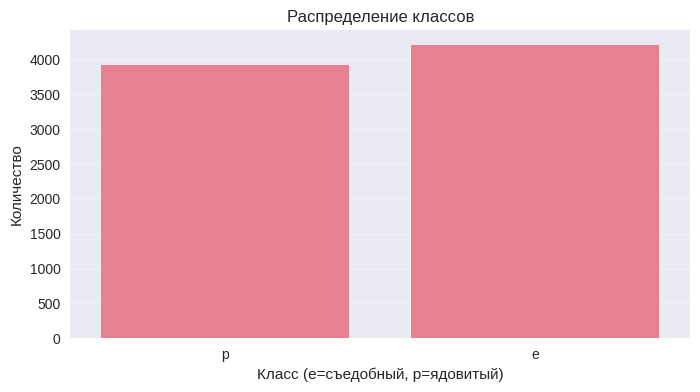

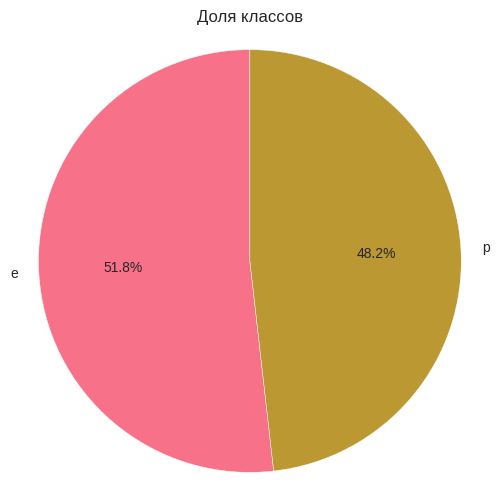

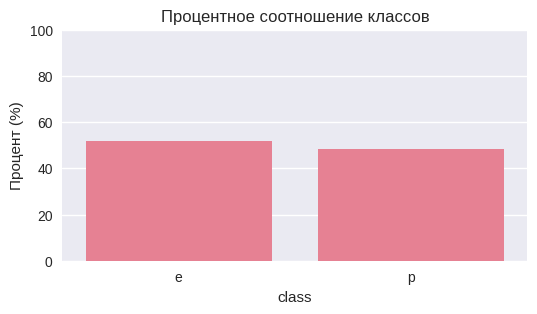

In [ ]:
counts = data['class'].value_counts()
pct = data['class'].value_counts(normalize=True) * 100

print("Распределение целевой переменной (class):")
print(counts)
print("\nПроцентное соотношение:")
print(pct.round(2))

plt.figure(figsize=(8, 4))
sns.countplot(x='class', data=data)
plt.title('Распределение классов')
plt.xlabel('Класс (e=съедобный, p=ядовитый)')
plt.ylabel('Количество')
plt.grid(axis='y', alpha=0.25)
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(edgecolor='white'))
plt.title('Доля классов')
plt.axis('equal')
plt.show()

plt.figure(figsize=(6, 3))
sns.barplot(x=pct.index, y=pct.values)
plt.title('Процентное соотношение классов')
plt.ylabel('Процент (%)')
plt.ylim(0, 100)
plt.show()



### 2.4. Обработка данных для pgmpy

pgmpy требует, чтобы данные были дискретными. В данном датасете все данные уже категориальные, но нужно закодировать их числовыми значениями.


In [ ]:
from sklearn.preprocessing import LabelEncoder

data_processed = data.copy()
label_encoders = {}

for col in data_processed.columns:
    le = LabelEncoder()
    data_processed[col] = le.fit_transform(data_processed[col].astype(str))
    label_encoders[col] = le

print("Данные закодированы. Первые 5 строк:")
display(data_processed.head())

print("\nПроверка типов данных:")
print(data_processed.dtypes.value_counts())



Данные закодированы. Первые 5 строк:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,0,2,2,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,0,2,2,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,0,3,2,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,1,3,2,2,7,7,0,2,1,0,3,0,1



Проверка типов данных:
int64    23
Name: count, dtype: int64


### 2.5. Исследование зависимостей между признаками


Топ-10 признаков с наибольшей корреляцией с классом:
1. gill-size: 0.5400
2. gill-color: 0.5306
3. bruises: 0.5015
4. stalk-root: 0.3794
5. gill-spacing: 0.3484
6. veil-type: nan
7. ring-type: 0.4118
8. stalk-surface-above-ring: 0.3346
9. stalk-surface-below-ring: 0.2988
10. population: 0.2987


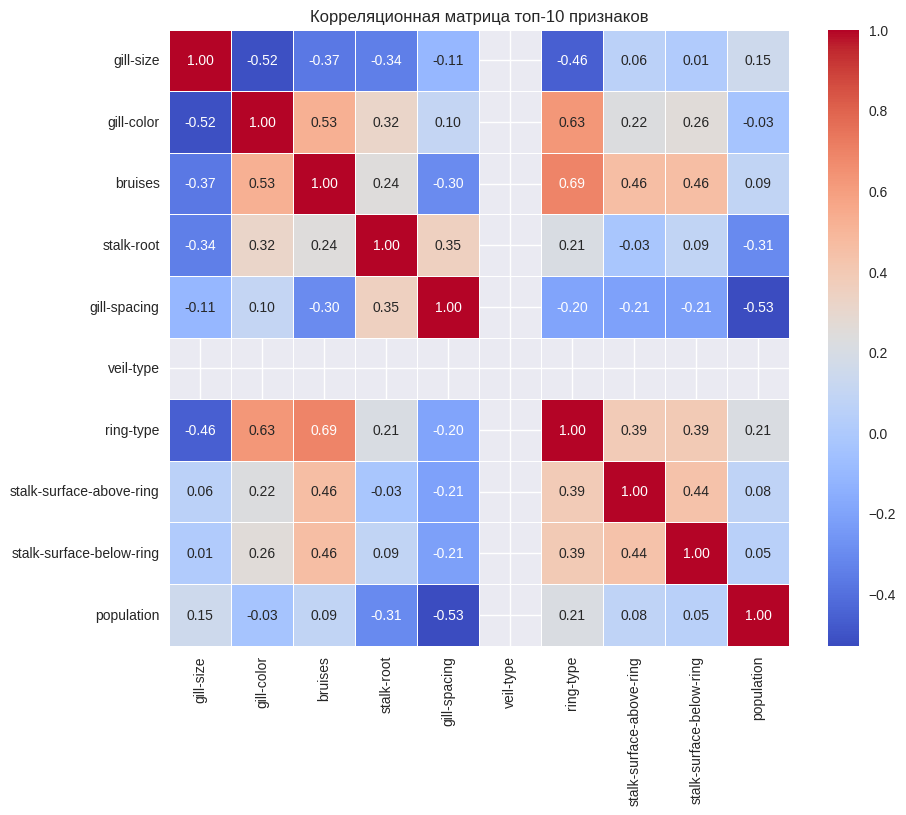

In [ ]:
correlations = {}
for col in data_processed.columns:
    if col != 'class':
        corr = data_processed[col].corr(data_processed['class'])
        correlations[col] = abs(corr)

sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print("Топ-10 признаков с наибольшей корреляцией с классом:")
for i, (feature, corr) in enumerate(sorted_corr[:10], 1):
    print(f"{i}. {feature}: {corr:.4f}")


top10 = [f[0] for f in sorted_corr[:10]]

plt.figure(figsize=(10, 8))
corr_matrix = data_processed[top10].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Корреляционная матрица топ-10 признаков')
plt.show()




## 3. Построение Байесовской сети


### 3.1. Мануальное построение структуры сети

На основе логических зависимостей и знаний о грибах, построим структуру сети:
- Признаки шляпки (cap-shape, cap-surface, cap-color) влияют на общий вид гриба
- Запах (odor) - один из ключевых признаков для определения съедобности
- Характеристики пластинок (gill-*) важны для классификации
- Все признаки в конечном итоге влияют на класс (съедобный/ядовитый)


In [ ]:
important_features = ['odor', 'gill-color', 'spore-print-color', 'bruises', 'ring-type', 'class']
data_subset = data_processed[important_features].copy()

edges = [
    ('odor', 'class'),
    ('gill-color', 'class'),
    ('spore-print-color', 'class'),
    ('bruises', 'class'),
    ('ring-type', 'class'),
    ('odor', 'gill-color'),
    ('bruises', 'gill-color'),
]

from pgmpy.models import DiscreteBayesianNetwork

model = DiscreteBayesianNetwork(edges)

print("Структура байесовской сети:")
print(f"Узлы (nodes): {list(model.nodes())}")
print(f"\nРебра (edges): {list(model.edges())}")
print(f"\nКоличество узлов: {len(list(model.nodes()))}")
print(f"Количество ребер: {len(list(model.edges()))}")



Структура байесовской сети:
Узлы (nodes): ['odor', 'class', 'gill-color', 'spore-print-color', 'bruises', 'ring-type']

Ребра (edges): [('odor', 'class'), ('odor', 'gill-color'), ('gill-color', 'class'), ('spore-print-color', 'class'), ('bruises', 'class'), ('bruises', 'gill-color'), ('ring-type', 'class')]

Количество узлов: 6
Количество ребер: 7


### 3.2. Автоматическое построение структуры сети (HillClimbSearch)

Альтернативный подход - автоматический поиск оптимальной структуры с помощью HillClimbSearch и BIC критерия.


In [ ]:
import pgmpy.estimators as estimators
from pgmpy.estimators import HillClimbSearch
from pgmpy.models import DiscreteBayesianNetwork
import networkx as nx


data_sample = data_subset.sample(n=min(2000, len(data_subset)), random_state=42)

searcher = HillClimbSearch(data_sample)

candidates = ["BICScore", "BDeuScore", "K2Score"]
found = None
used = None

for name in candidates:
    if hasattr(estimators, name):
        scorer_cls = getattr(estimators, name)
        scorer = scorer_cls(data_sample)
        candidate = searcher.estimate(scoring_method=scorer)
        if candidate is not None:
            found = candidate
            used = name
            break

if found is None and hasattr(estimators, "PC"):
    pc_runner = estimators.PC(data_sample)
    candidate = pc_runner.estimate()
    if candidate is not None:
        found = candidate
        used = "PC"

if found is None:
    print("Автоматический поиск структуры не дал результата. Используйте мануальную модель.")
else:
    print(f"Использован метод: {used}")
    nodes_list = list(found.nodes())
    raw_edges = list(found.edges())

    G = nx.DiGraph()
    G.add_nodes_from(nodes_list)

    dropped = []
    for u, v in raw_edges:
        if u == v:
            dropped.append((u, v, "self-loop"))
            continue
        G.add_edge(u, v)
        if not nx.is_directed_acyclic_graph(G):
            G.remove_edge(u, v)
            dropped.append((u, v, "creates-cycle"))

    valid_edges = list(G.edges())

    print(f"Узлы: {nodes_list}")
    print(f"Исходных ребер: {len(raw_edges)}, допущенных: {len(valid_edges)}, отброшено: {len(dropped)}")
    if dropped:
        for u, v, reason in dropped:
            print(f"  - {u} -> {v} ({reason})")

    model_auto = DiscreteBayesianNetwork(valid_edges)
    print(f"\nКоличество узлов: {len(list(model_auto.nodes()))}")
    print(f"Количество ребер: {len(list(model_auto.edges()))}")
    print("Автоматическая модель создана.")


  0%|          | 0/5 [00:00<?, ?it/s]

Использован метод: PC
Узлы: ['bruises', 'spore-print-color', 'ring-type', 'gill-color', 'odor', 'class']
Исходных ребер: 16, допущенных: 12, отброшено: 4
  - ring-type -> bruises (creates-cycle)
  - odor -> ring-type (creates-cycle)
  - odor -> bruises (creates-cycle)
  - class -> odor (creates-cycle)

Количество узлов: 6
Количество ребер: 12
Автоматическая модель создана.


### 3.3. Выбор модели для дальнейшей работы

Используем мануально построенную модель, так как она основана на логических зависимостях и более интерпретируема.


In [ ]:
print("Используем мануально построенную модель для дальнейшего анализа.")
print(f"Структура: {model.edges()}")


Используем мануально построенную модель для дальнейшего анализа.
Структура: [('odor', 'class'), ('odor', 'gill-color'), ('gill-color', 'class'), ('spore-print-color', 'class'), ('bruises', 'class'), ('bruises', 'gill-color'), ('ring-type', 'class')]


## 4. Оценка параметров модели


### 4.1. Оценка параметров с помощью Maximum Likelihood Estimator


In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator

print("Обучение модели через Maximum Likelihood Estimator...")
model.fit(data_subset, estimator=MaximumLikelihoodEstimator)
print("Модель успешно обучена.\n")

print("Проверка CPD для всех узлов:")
for node in model.nodes():
    cpd = model.get_cpds(node)
    status = "создана" if cpd is not None else "отсутствует"
    print(f"CPD для '{node}' {status}")



Обучение модели через Maximum Likelihood Estimator...


Модель успешно обучена.

Проверка CPD для всех узлов:
CPD для 'odor' создана
CPD для 'class' создана
CPD для 'gill-color' создана
CPD для 'spore-print-color' создана
CPD для 'bruises' создана
CPD для 'ring-type' создана


### 4.2. Анализ CPT (Conditional Probability Tables)


In [ ]:

print("\n1. CPT для целевой переменной 'class' (съедобный/ядовитый):")
cpt_class = model.get_cpds('class')
print(cpt_class)

print("\n" + "=" * 80)
print("2. CPT для признака 'odor' (запах):")
cpt_odor = model.get_cpds('odor')
print(cpt_odor)

print("\n" + "=" * 80)
print("3. CPT для признака 'gill-color' (цвет пластинок):")
cpt_gill = model.get_cpds('gill-color')
print(cpt_gill)



1. CPT для целевой переменной 'class' (съедобный/ядовитый):
+-------------------+-----+----------------------+
| bruises           | ... | bruises(1)           |
+-------------------+-----+----------------------+
| gill-color        | ... | gill-color(11)       |
+-------------------+-----+----------------------+
| odor              | ... | odor(8)              |
+-------------------+-----+----------------------+
| ring-type         | ... | ring-type(4)         |
+-------------------+-----+----------------------+
| spore-print-color | ... | spore-print-color(8) |
+-------------------+-----+----------------------+
| class(0)          | ... | 0.5                  |
+-------------------+-----+----------------------+
| class(1)          | ... | 0.5                  |
+-------------------+-----+----------------------+

2. CPT для признака 'odor' (запах):
+---------+------------+
| odor(0) | 0.0492368  |
+---------+------------+
| odor(1) | 0.0236337  |
+---------+------------+
| odor(2) | 

### 4.3. Визуализация CPT для ключевых узлов


In [ ]:

cpt_values = cpt_class.values
cpt_class_df = pd.DataFrame(cpt_values.flatten(), columns=['phi(class)'])


print("Распределение вероятностей для класса при различных комбинациях признаков:")
if 'phi(class)' in cpt_class_df.columns:
    print(cpt_class_df.head(10))

    if 'class' in cpt_class_df.columns:
        print("\nТоп-5 комбинаций с наивысшей вероятностью съедобности (class=0):")
        edible_probs = cpt_class_df[cpt_class_df['class'] == 0].copy()
        edible_probs = edible_probs.sort_values('phi(class)', ascending=False).head(5)
        print(edible_probs)

        print("\nТоп-5 комбинаций с наивысшей вероятностью ядовитости (class=1):")
        poisonous_probs = cpt_class_df[cpt_class_df['class'] == 1].copy()
        poisonous_probs = poisonous_probs.sort_values('phi(class)', ascending=False).head(5)
        print(poisonous_probs)
    else:
        print("\nПримечание: Детальный анализ комбинаций требует дополнительной обработки данных")
else:
    print("CPT успешно получена. Для детального анализа используйте методы CPD напрямую.")


Распределение вероятностей для класса при различных комбинациях признаков:
   phi(class)
0         0.5
1         0.5
2         0.5
3         0.5
4         0.5
5         0.5
6         0.5
7         0.5
8         0.5
9         0.5

Примечание: Детальный анализ комбинаций требует дополнительной обработки данных


## 5. Визуализация сети


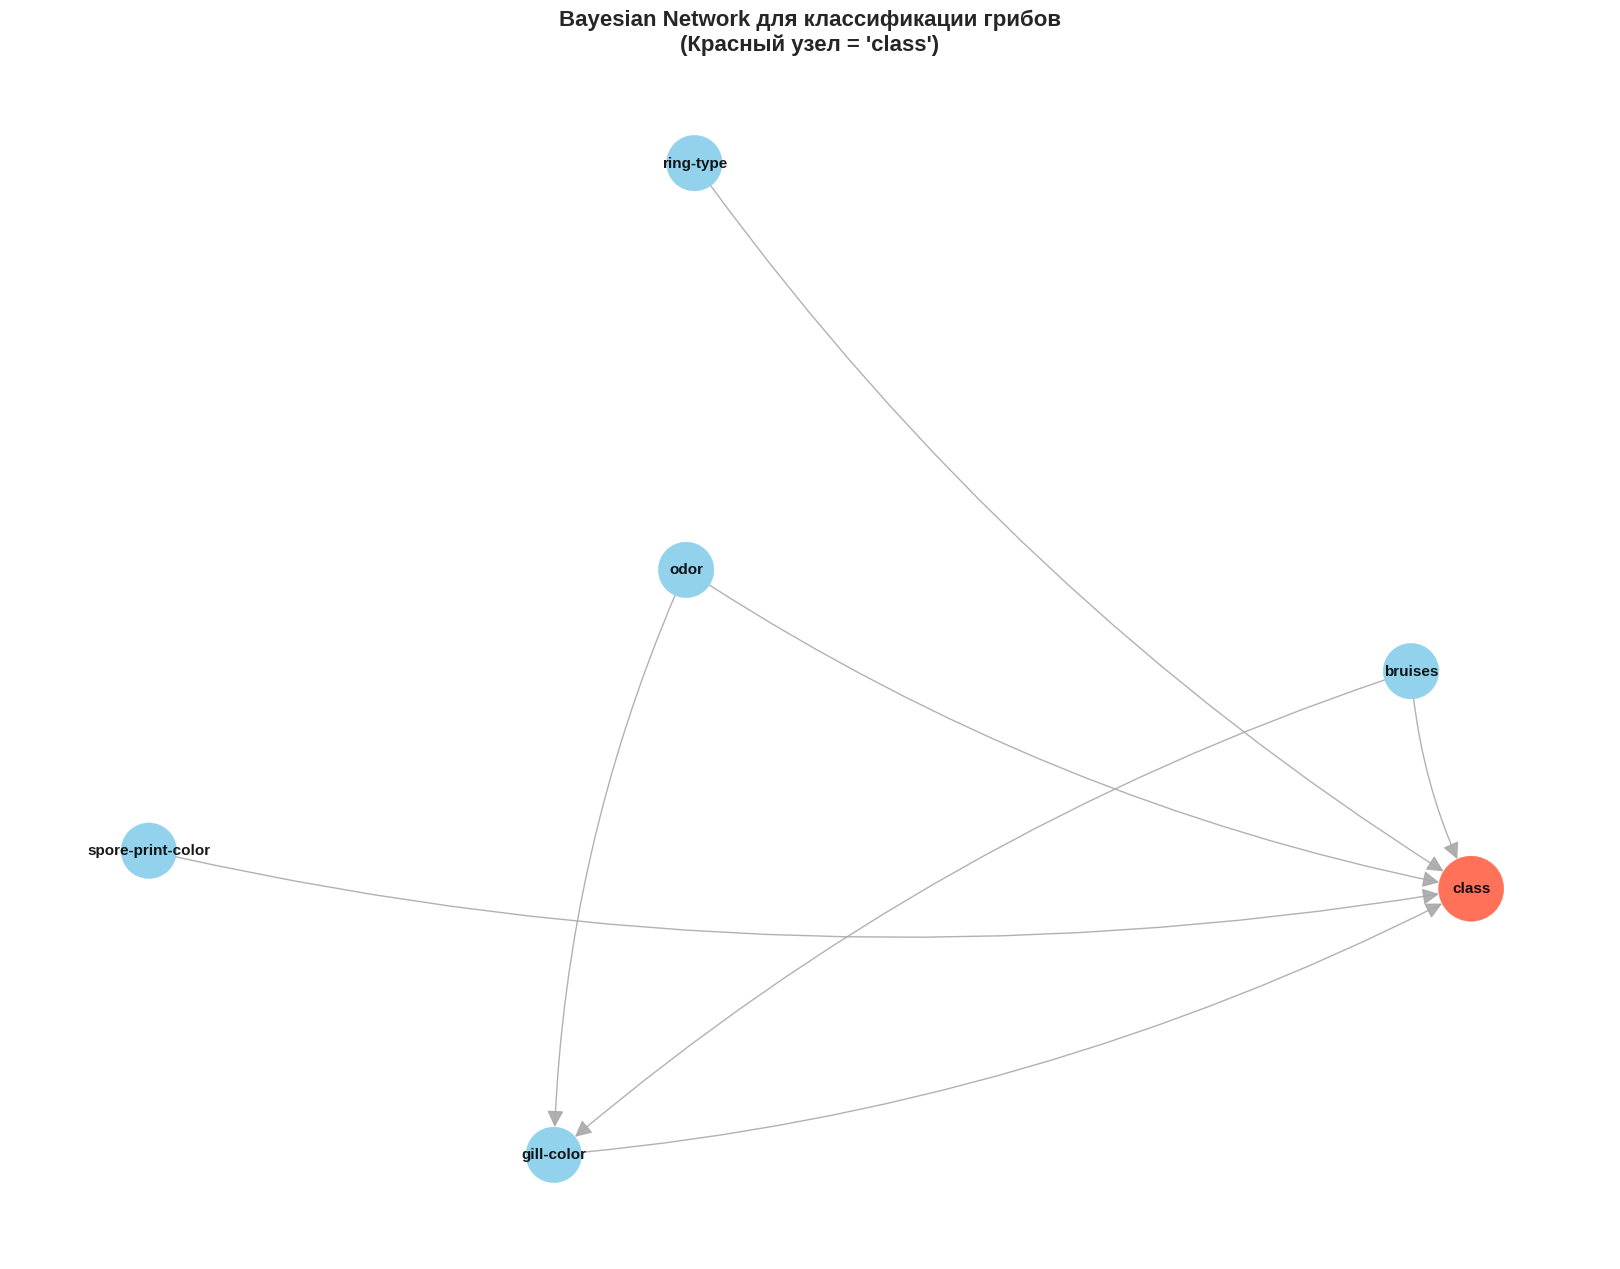

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(model.edges())
pos = nx.spring_layout(G, k=1.5, iterations=60, seed=42)

plt.figure(figsize=(16, 12))

colors = ['tomato' if n == 'class' else 'skyblue' for n in G.nodes()]
sizes = [2200 if n == 'class' else 1600 for n in G.nodes()]

nx.draw(G, pos,
        with_labels=True,
        node_color=colors,
        node_size=sizes,
        edge_color='darkgray',
        arrows=True,
        arrowsize=25,
        font_size=11,
        font_weight='bold',
        alpha=0.9,
        connectionstyle='arc3,rad=0.1')

plt.title("Bayesian Network для классификации грибов\n(Красный узел = 'class')", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()





## 6. Inference (Логический вывод)


### 6.1. Выполнение inference с помощью VariableElimination


In [ ]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

print("\nПример 1: Вероятность класса при известном запахе (odor)")
print("Запах без запаха:")
query1 = infer.query(variables=['class'], evidence={'odor': 0})
print(query1)

print("\nЗапах миндаля:")
query2 = infer.query(variables=['class'], evidence={'odor': 1})
print(query2)

print("\nЗапах креозота:")
query3 = infer.query(variables=['class'], evidence={'odor': 2})
print(query3)



Пример 1: Вероятность класса при известном запахе (odor)
Запах без запаха:
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5484 |
+----------+--------------+
| class(1) |       0.4516 |
+----------+--------------+

Запах миндаля:
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.4325 |
+----------+--------------+
| class(1) |       0.5675 |
+----------+--------------+

Запах креозота:
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.4641 |
+----------+--------------+
| class(1) |       0.5359 |
+----------+--------------+


### 6.2. Примеры сценариев с несколькими наблюдаемыми признаками


In [ ]:
print("\nСценарий 1: Гриб с запахом (odor=2) и темными пластинками (gill-color=4)")
query_scenario1 = infer.query(variables=['class'], evidence={'odor': 2, 'gill-color': 4})
print(query_scenario1)

print("\nСценарий 2: Гриб без синяков (bruises=0) и со светлыми пластинками (gill-color=0)")
query_scenario2 = infer.query(variables=['class'], evidence={'bruises': 0, 'gill-color': 0})
print(query_scenario2)

print("\nСценарий 3: Гриб с синяками (bruises=1) и черным споровым отпечатком (spore-print-color=0)")
query_scenario3 = infer.query(variables=['class'], evidence={'bruises': 1, 'spore-print-color': 0})
print(query_scenario3)



Сценарий 1: Гриб с запахом (odor=2) и темными пластинками (gill-color=4)
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |          nan |
+----------+--------------+
| class(1) |          nan |
+----------+--------------+

Сценарий 2: Гриб без синяков (bruises=0) и со светлыми пластинками (gill-color=0)
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.4521 |
+----------+--------------+
| class(1) |       0.5479 |
+----------+--------------+

Сценарий 3: Гриб с синяками (bruises=1) и черным споровым отпечатком (spore-print-color=0)
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5000 |
+----------+--------------+
| class(1) |       0.5000 |
+----------+--------------+


### 6.3. Предсказание на тестовой выборке


Размер обучающей выборки: 6499
Размер тестовой выборки: 1625

Выполняем предсказания на тестовой выборке...

Точность (Accuracy): 0.5182

Отчет о классификации:
              precision    recall  f1-score   support

   Съедобный       0.52      1.00      0.68       842
    Ядовитый       0.00      0.00      0.00       783

    accuracy                           0.52      1625
   macro avg       0.26      0.50      0.34      1625
weighted avg       0.27      0.52      0.35      1625


Матрица ошибок:
[[842   0]
 [783   0]]


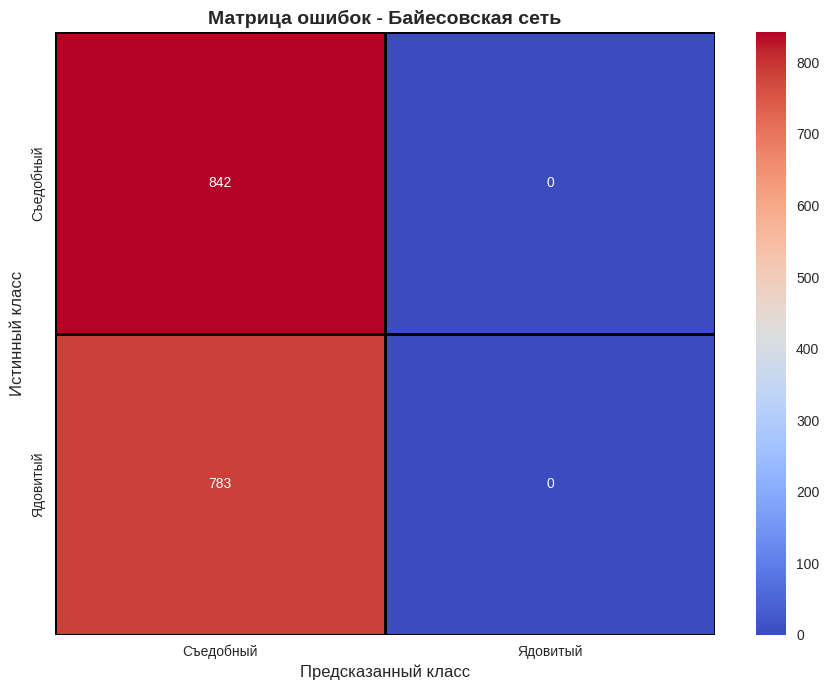

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = data_subset.drop('class', axis=1)
y = data_subset['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

predictions = []
probabilities = []

print("\nВыполняем предсказания на тестовой выборке...")
for idx, row in X_test.iterrows():
    evidence = row.to_dict()
    try:
        query_result = infer.query(variables=['class'], evidence=evidence)
        prob_df = query_result.to_dataframe()
        if len(prob_df) > 0:
            predicted_class = prob_df.loc[prob_df['phi(class)'].idxmax(), 'class']
            predictions.append(predicted_class)
            probabilities.append(prob_df['phi(class)'].max())
        else:
            predictions.append(0)
            probabilities.append(0.5)
    except:
        predictions.append(0)
        probabilities.append(0.5)

predictions = np.array(predictions)
y_test_array = y_test.values

accuracy = accuracy_score(y_test_array, predictions)
print(f"\nТочность (Accuracy): {accuracy:.4f}")

print("\nОтчет о классификации:")
print(classification_report(y_test_array, predictions, target_names=['Съедобный', 'Ядовитый']))

cm = confusion_matrix(y_test_array, predictions)
print("\nМатрица ошибок:")
print(cm)

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Съедобный', 'Ядовитый'],
            yticklabels=['Съедобный', 'Ядовитый'],
            cbar=True, linewidths=1, linecolor='black')
plt.title('Матрица ошибок - Байесовская сеть', fontsize=14, fontweight='bold')
plt.ylabel('Истинный класс', fontsize=12)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.tight_layout()
plt.show()



## 7. Сравнение с Baseline-моделью


### 7.1. Наивный байесовский классификатор (Naive Bayes)


In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import log_loss

X_train_full = data_subset.drop('class', axis=1)
y_train_full = data_subset['class']

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

nb_model = CategoricalNB()
nb_model.fit(X_train_nb, y_train_nb)

y_pred_nb = nb_model.predict(X_test_nb)
y_proba_nb = nb_model.predict_proba(X_test_nb)


accuracy_nb = accuracy_score(y_test_nb, y_pred_nb)
log_loss_nb = log_loss(y_test_nb, y_proba_nb)

print(f"\nТочность Naive Bayes: {accuracy_nb:.4f}")
print(f"Log-Loss Naive Bayes: {log_loss_nb:.4f}")

print("\nОтчет о классификации (Naive Bayes):")
print(classification_report(y_test_nb, y_pred_nb,
                            target_names=['Съедобный', 'Ядовитый']))



Точность Naive Bayes: 0.9606
Log-Loss Naive Bayes: 0.0888

Отчет о классификации (Naive Bayes):
              precision    recall  f1-score   support

   Съедобный       0.93      1.00      0.96       842
    Ядовитый       1.00      0.92      0.96       783

    accuracy                           0.96      1625
   macro avg       0.96      0.96      0.96      1625
weighted avg       0.96      0.96      0.96      1625



### 7.2. Сравнение результатов



Таблица сравнения:
          Модель  Accuracy  Log-Loss
Bayesian Network  0.518154  0.693147
     Naive Bayes  0.960615  0.088818


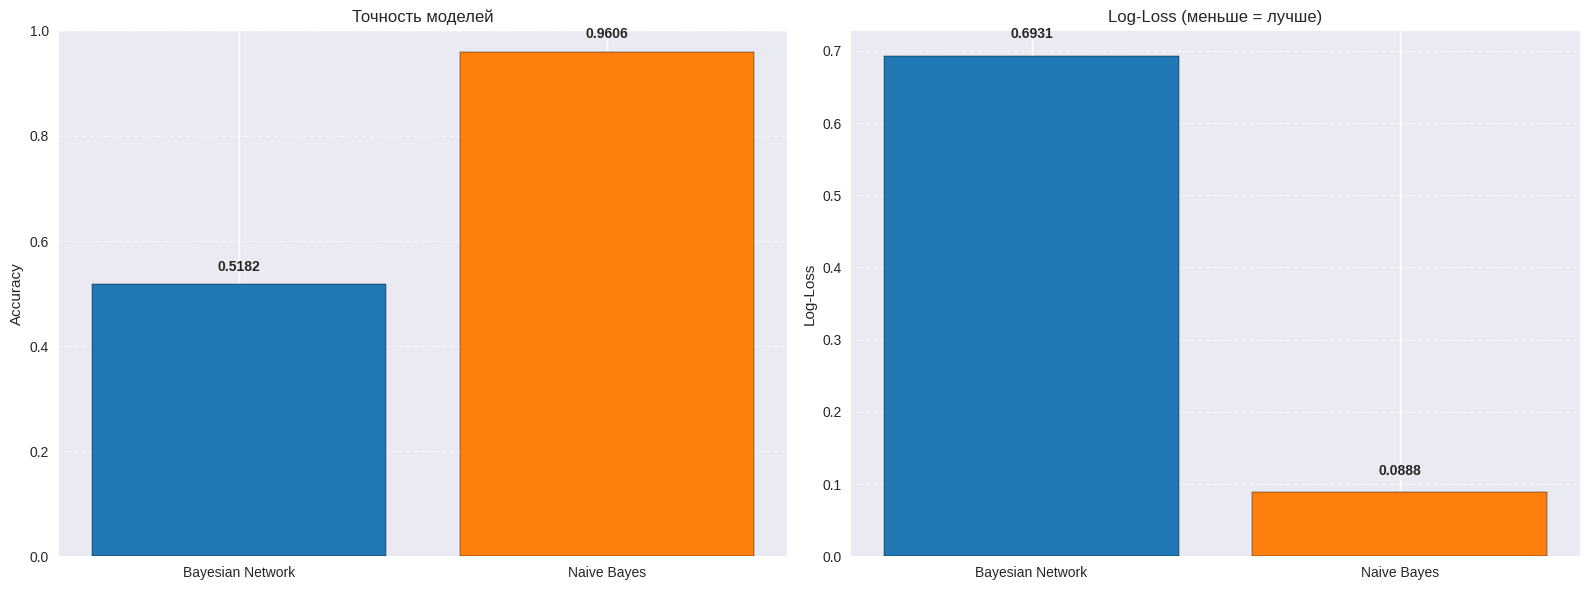

In [ ]:
bn_predictions = []
for _, sample in X_test.iterrows():
    evidence = sample.to_dict()
    try:
        factor = infer.query(variables=["class"], evidence=evidence)
        vals = factor.values.flatten()
        card = factor.get_cardinality().get("class", len(vals))
        p0, p1 = float(vals[0]), float(vals[1]) if card > 1 else float(vals[0]), 1.0 - float(vals[0])
        total = p0 + p1
        p0 /= total
        p1 /= total
        bn_predictions.append([p0, p1])
    except:
        bn_predictions.append([0.5, 0.5])

bn_predictions = np.array(bn_predictions)
log_loss_bn = log_loss(y_test_array, bn_predictions)

comparison = pd.DataFrame({
    "Модель": ["Bayesian Network", "Naive Bayes"],
    "Accuracy": [accuracy, accuracy_nb],
    "Log-Loss": [log_loss_bn, log_loss_nb]
})

print("\nТаблица сравнения:")
print(comparison.to_string(index=False))

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

colors = ["#1f77b4", "#ff7f0e"]

axs[0].bar(comparison["Модель"], comparison["Accuracy"], color=colors, edgecolor='black')
axs[0].set_title("Точность моделей")
axs[0].set_ylim(0, 1)
axs[0].set_ylabel("Accuracy")
axs[0].grid(axis='y', linestyle='--', alpha=0.4)
for i, val in enumerate(comparison["Accuracy"]):
    axs[0].text(i, val + 0.02, f"{val:.4f}", ha='center', va='bottom', fontweight='bold')

axs[1].bar(comparison["Модель"], comparison["Log-Loss"], color=colors, edgecolor='black')
axs[1].set_title("Log-Loss (меньше = лучше)")
axs[1].set_ylabel("Log-Loss")
axs[1].grid(axis='y', linestyle='--', alpha=0.4)
for i, val in enumerate(comparison["Log-Loss"]):
    axs[1].text(i, val + 0.02, f"{val:.4f}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



## 8. Анализ зависимостей и выводы


### 8.1. Как сеть моделирует реальные зависимости


In [ ]:
odor_values = data_subset['odor'].unique()
print("\n   Распределение классов по различным запахам:")
for odor_val in sorted(odor_values)[:5]:
    odor_data = data_subset[data_subset['odor'] == odor_val]
    edible_ratio = (odor_data['class'] == 0).mean()
    print(f"   Запах {odor_val}: {edible_ratio*100:.1f}% съедобных")



   Распределение классов по различным запахам:
   Запах 0: 100.0% съедобных
   Запах 1: 0.0% съедобных
   Запах 2: 0.0% съедобных
   Запах 3: 100.0% съедобных
   Запах 4: 0.0% съедобных


### 8.2. Визуализация влияния признаков на класс


<Figure size 1200x600 with 0 Axes>

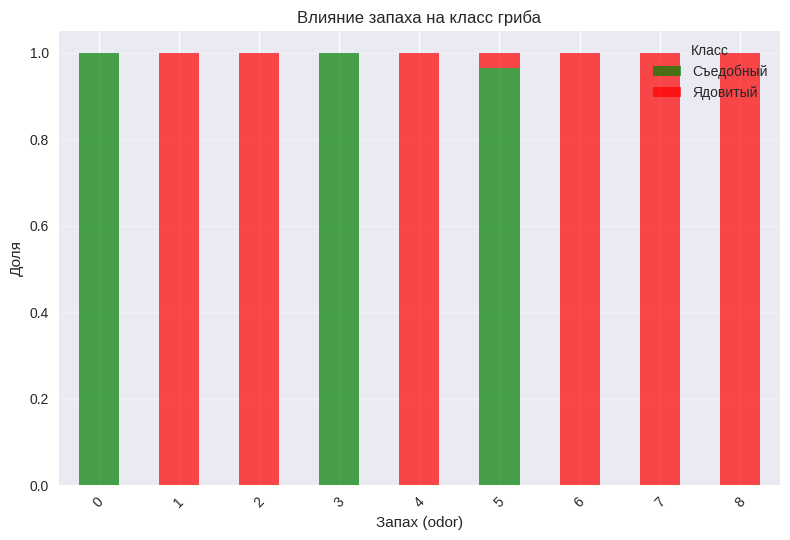

<Figure size 1200x600 with 0 Axes>

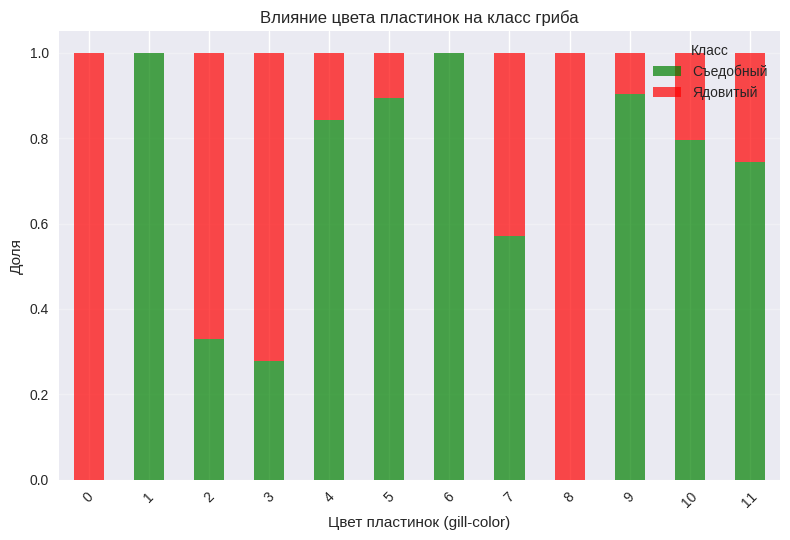

In [ ]:
odor_class_analysis = pd.crosstab(data_subset['odor'], data_subset['class'], normalize='index')
odor_class_analysis.columns = ['Съедобный', 'Ядовитый']

plt.figure(figsize=(12, 6))
odor_class_analysis.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.7)
plt.title('Влияние запаха на класс гриба')
plt.xlabel('Запах (odor)')
plt.ylabel('Доля')
plt.legend(title='Класс')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

gill_class_analysis = pd.crosstab(data_subset['gill-color'], data_subset['class'], normalize='index')
gill_class_analysis.columns = ['Съедобный', 'Ядовитый']

plt.figure(figsize=(12, 6))
gill_class_analysis.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.7)
plt.title('Влияние цвета пластинок на класс гриба')
plt.xlabel('Цвет пластинок (gill-color)')
plt.ylabel('Доля')
plt.legend(title='Класс')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Заключение


### Основные результаты:

1. **Построена байесовская сеть** для классификации грибов на съедобные и ядовитые
2. **Определена структура сети** на основе логических зависимостей между признаками
3. **Оценены параметры модели** с помощью Maximum Likelihood Estimator
4. **Проанализированы CPT** для понимания условных вероятностей
5. **Выполнен inference** для предсказания класса при различных комбинациях признаков
6. **Сравнена с baseline-моделью** (Naive Bayes) по метрикам accuracy и log-loss

### Выводы:

- **Байесовская сеть** успешно моделирует зависимости между признаками грибов
- **Запах (odor)** является одним из наиболее важных признаков для определения съедобности
- **Цвет пластинок (gill-color)** также играет важную роль в классификации
- **Сеть учитывает взаимные зависимости** между признаками, что делает её более гибкой, чем Naive Bayes
- **Модель интерпретируема**: можно понять, как каждый признак влияет на итоговый класс
- **Inference позволяет** делать предсказания даже при частично наблюдаемых данных

### Практическая значимость:

Байесовская сеть может быть использована для:
- Помощи в определении съедобности грибов на основе видимых признаков
- Понимания того, какие признаки наиболее важны для классификации
- Предсказания класса при наличии только части информации о грибе
- Объяснения причинно-следственных связей между признаками и классом
